In [23]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import h5py
import pandas as pd
import visualizing_funcs as vf
import calculations as calc
import loading_data as ld
from settings import *

In [2]:
##Define files
filename0=data_files_path + "/3D_temperature_9_dist_bins_nside_128.hdf5"
filename1=data_files_path + "/3D_temperature_17_dist_bins_nside_128.hdf5"


In [3]:

##Function to load positions and distance of the different star formation tracers
def load_sftracer(tracer_data):
    '''
    A function that loads the longitude, latitude and distance of a star formation tracer. It converts them from degrees to radians, and converts the latitude into colatitude. If no distance is found, the function only returns theta and phi. 

    Parameters: 
        tracer_data-------------------------------pandas dataframe, must have a component 'l' and a component 'b', optionally can have 'D'

    Returns:
        long--------------------------------------array-like, longitude in degrees
        lat---------------------------------------array-like, latitude in degrees
        distance----------------------------------array-like, distance in kpc
    '''
    long = tracer_data['l']
    lat = tracer_data['b']

    if 'D' in tracer_data: #If the file has distance create a distance variable and return it
        distance = tracer_data['D'] 
        
        return long, lat, distance
    else: #If there is no distance only return that and phi
        print("No distance measurement")
        return long, lat


##Function to assign each position to one of the distance slices
def assign_distance_slice(data_dict, long, lat, distance):
    '''
    A function that assigns one of the distance slices from the 3D dust temperature map, to the position of each object. Based on the distance it checks to see in which slice it belongs and then makes a new array of the positions with their assigned distance slice. 

    Parameters:
        data_dict-------------------------------dictionary, dictionary of one of the 3D dust temperature maps
        long------------------------------------array-like, longitude of the object in degrees
        lat-------------------------------------array-like, latitude of an object in degrees
        distance--------------------------------array-like, distance to object in kpc

    Returns:
        long_sliced-----------------------------array-like, longitude that now has an assigned distance slice
        lat_sliced------------------------------array-like, latitude that now has an assigned distance slice
        
    '''
    
    distance_bins = data_dict["nr_of_distance_bins"]
    distance_slices = data_dict["distance_slices"]
    long_slice = [[] for i in range(distance_bins)] #Make empty array to store positions with distance slices
    lat_slice = [[] for i in range(distance_bins)]
    outofrange_count = 0 ##Adding a way to track how many distances are out of range

    for idx, dist in enumerate(distance): #Do this for each distance value
        found = False #Introduce flag to check if a distance was found
        for ds_idx in range(distance_bins): #Check to see which distance slice sf distance is
            if ds_idx ==0 and dist < distance_slices[0]: #Condition for first distance slice
                long_slice[0].append(long[0])
                lat_slice[0].append(lat[0])
                found = True
                break
                  
            elif ds_idx > 0 and distance_slices[ds_idx-1] <= dist <= distance_slices[ds_idx]: #Condition for all other distance slices
                long_slice[ds_idx].append(long[idx])
                lat_slice[ds_idx].append(lat[idx])
                found = True
                break
        if found == False :
            outofrange_count += 1 ##Add to counter

    print(f"{outofrange_count} objects had distances out of range")
                
    return long_slice, lat_slice #Return "sliced" values
            

def plot_3D_temperature_slice_maps(data_dict, theta, phi, theta2, phi2):
    '''
    A function make a healpix map of the 3D dust temperature maps at each distance slices. It overplots a scatter plot of different star formation tracers

    Parameters:
        data_dict-------------------------------dictionary, dictionary of one of the 3D dust temperature maps
        theta-----------------------------------array-like, colatitude of a YSO in radians
        phi-------------------------------------array-like, longitude of a YSO in radians
        theta2-----------------------------------array-like, colatitude of a SFC in radians
        phi2-------------------------------------array-like, longitude of a SFC in radians

    Returns:
        A healpix map at each distance slice with two scatter plots overlaid. 
    '''
    Ts = data_dict["temperatures"]
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]
    for ds_index in range(model_nslices):                                 
        hp.mollview(Ts[:,ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')
        hp.projscatter(theta2[ds_index], phi2[ds_index], marker='*', s=100, color='red', alpha=0.4) #Added plotting positions of sf tracer
        hp.projscatter(theta[ds_index], phi[ds_index], s = 100, marker='o', alpha = 0.9, color='blue') #Added plotting positions of sf tracer
        plt.legend(['YSOs', 'SFCs'])
        plt.savefig('tempmap_{}.pdf'.format(ds_index))
        


In [22]:
##Load temperature map

#data_dict0=load_3D_temperature_data(filename0) #Not needed for this project but likely in the future
data_dict1=ld.load_just_temperature_data(filename1)

In [5]:
##Define Nside and Npix
Nside = 128 ##based on dust map
Npix = hp.nside2npix(Nside)

In [6]:
##Get positions of the YSOs
#This is for all YSOs in the catalog
YSOs = pd.read_csv(csv_files_path + "/SPICY_YSOs_new.csv")
l_ysos, b_ysos = load_sftracer(YSOs)

#Only the YSOs with distance
YSOs_with_dist = pd.read_csv(csv_files_path + "/YSOs_withdist.csv")
l_ysos_wdist, b_ysos_wdist, dist_ysos = load_sftracer(YSOs_with_dist)
#Get distances slices for YSOs
#l_ysos_sliced0, b_ysos_sliced0 = assign_distance_slice(data_dict0, l_ysos_wdist, b_ysos_wdist, dist_ysos)
l_ysos_sliced, b_ysos_sliced = assign_distance_slice(data_dict1, l_ysos_wdist, b_ysos_wdist, dist_ysos)

No distance measurement
1080 objects had distances out of range


In [7]:
##Get positions for Winston YSOs
winston_ysos = pd.read_csv(csv_files_path + "/Winston_YSOs_new.csv")

l_winston_ysos, b_winston_ysos = load_sftracer(winston_ysos)
##Have to remove indices with NaN values
valid_indices = ~np.isnan(l_winston_ysos) & ~np.isnan(b_winston_ysos)
l_winston_ysos = l_winston_ysos[valid_indices]
b_winston_ysos = b_winston_ysos[valid_indices]

No distance measurement


In [8]:
##Get positions of all KYSOs

kyso = pd.read_csv(csv_files_path + "/KYSO.csv")

l_kyso, b_kyso = load_sftracer(kyso)

##Get positions for KYSOs with distance

kyso_withdist = pd.read_csv(csv_files_path + "/KYSO_withdist.csv")

l_kyso_wdist, b_kyso_wdist, dist_kyso = load_sftracer(kyso_withdist)
l_kyso_sliced, b_kyso_sliced = assign_distance_slice(data_dict1, l_kyso_wdist, b_kyso_wdist, dist_kyso) 

No distance measurement
35 objects had distances out of range


In [9]:
##Get positions of the SFCs
linetoskip = [5, 7, 9, 12, 15, 23, 35, 36, 39] ##skipping lines that have two distances

SFCs = pd.read_csv(csv_files_path + "/SFC_Regions.csv", skiprows = linetoskip) ##read file, skipping lines

l_sfc, b_sfc, dist_sfc = load_sftracer(SFCs) ##get latitude, longitude and distance

#l_sfc_sliced0, b_sfc_sliced0 = assign_distance_slice(data_dict0, l_sfc, b_sfc, dist_sfc) 
l_sfc_sliced, b_sfc_sliced = assign_distance_slice(data_dict1, l_sfc, b_sfc, dist_sfc) ## get positions at different distances

2 objects had distances out of range


In [10]:
#Get positions for Lee SFCs

Lee_SFCs = pd.read_csv(csv_files_path + "/Lee_SFCs.csv")
l_lee, b_lee, dist_lee = load_sftracer(Lee_SFCs)

#l_lee_sliced0, b_lee_sliced0 = assign_distance_slice(data_dict0, l_lee, b_lee, dist_lee) 
l_lee_sliced, b_lee_sliced = assign_distance_slice(data_dict1, l_lee, b_lee, dist_lee) 

3 objects had distances out of range


In [11]:
#Look at star formation regions that we know in our solar neighbourhood
MolecClouds = pd.read_csv(csv_files_path + "/SFR_SolarNeighbourhood.csv")

l_clouds, b_clouds, dist_clouds = load_sftracer(MolecClouds)

dist_clouds = dist_clouds/1000 ## have to convert to kpc

l_clouds_sliced, b_clouds_sliced = assign_distance_slice(data_dict1, l_clouds, b_clouds, dist_clouds) 

0 objects had distances out of range


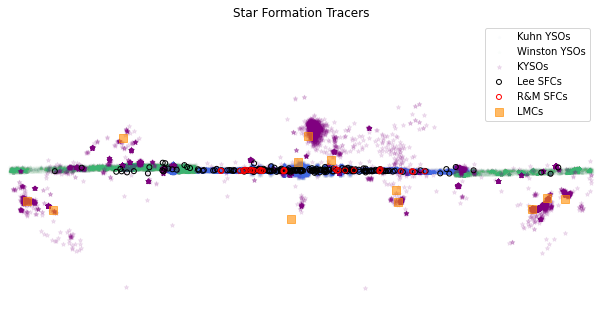

In [12]:
##Plot star formation tracers in sky on their own (not sliced yet)
hp.mollview(title = 'Star Formation Tracers') #Create empty map
hp.projscatter(l_ysos, b_ysos, lonlat=True, marker = '*', s=10, alpha=0.01, color='royalblue')
hp.projscatter(l_winston_ysos, b_winston_ysos, lonlat=True,  marker = '*', s=10, alpha=0.01, color='mediumseagreen')
hp.projscatter(l_kyso, b_kyso, lonlat=True, marker = '*', s=20, alpha=0.1, color='purple')
hp.projscatter(l_lee, b_lee, lonlat=True, marker = '.', facecolor='none', s=100, color='black')
hp.projscatter(l_sfc, b_sfc, lonlat=True, marker = '.', facecolors='none', s=100, color='red')
hp.projscatter(l_clouds, b_clouds, lonlat=True, marker = 's', s=80, alpha=0.6, color='darkorange')

#plt.savefig('Tracers_all.pdf')
plt.legend(['Kuhn YSOs','Winston YSOs','KYSOs', 'Lee SFCs', 'R&M SFCs', 'LMCs'])
plt.show()
plt.close()

In [13]:
##Plot temperature map
#plot_3D_temperature_slice_maps(data_dict1, theta_sfc_sliced, phi_sfc_sliced, theta_ysos_sliced, phi_ysos_sliced)

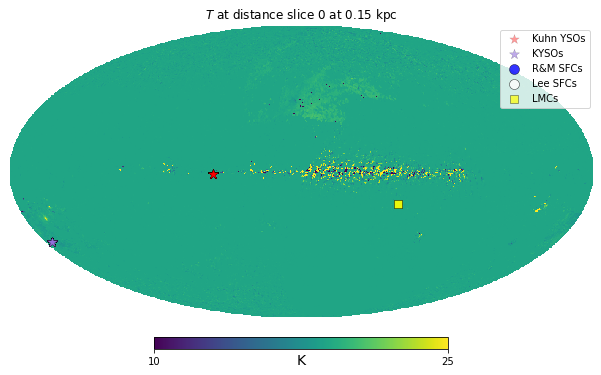

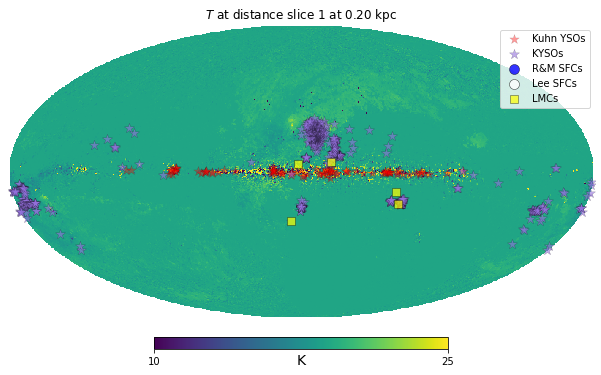

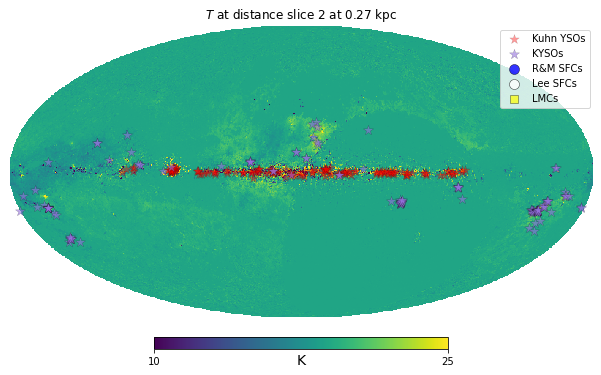

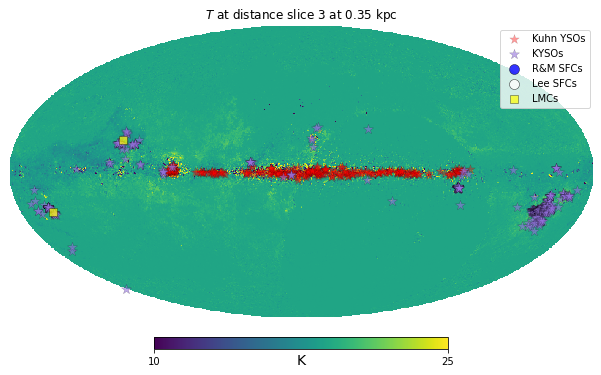

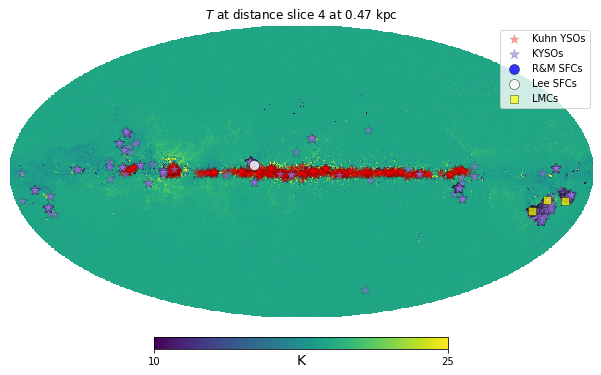

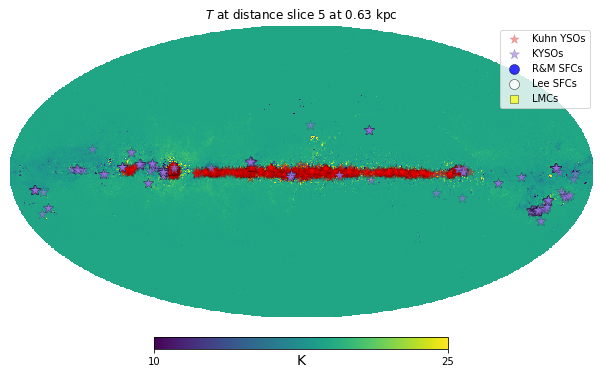

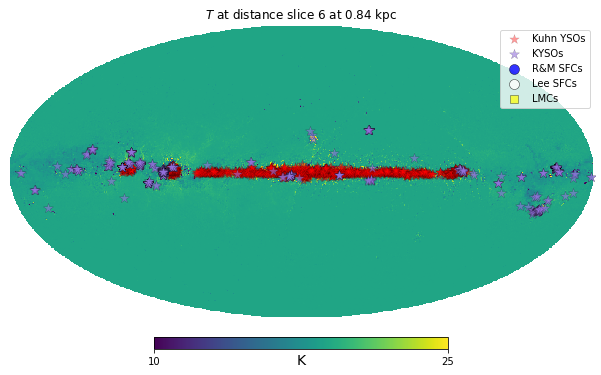

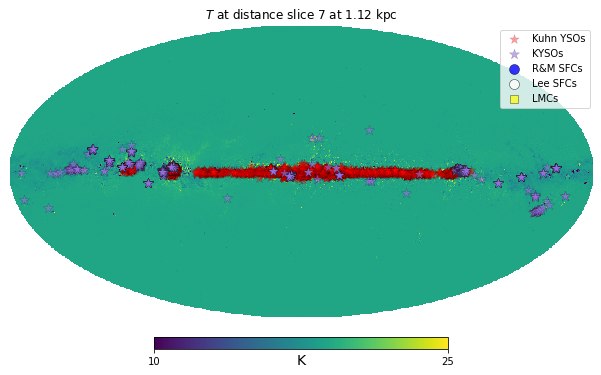

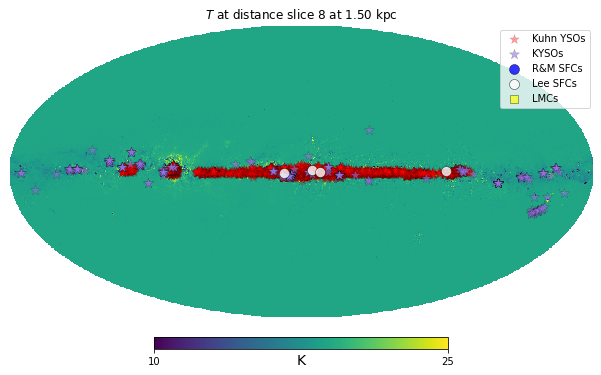

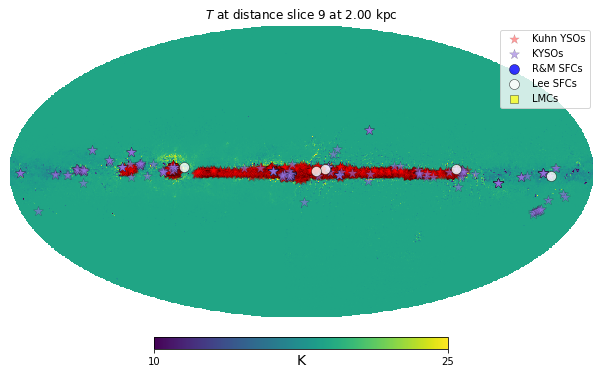

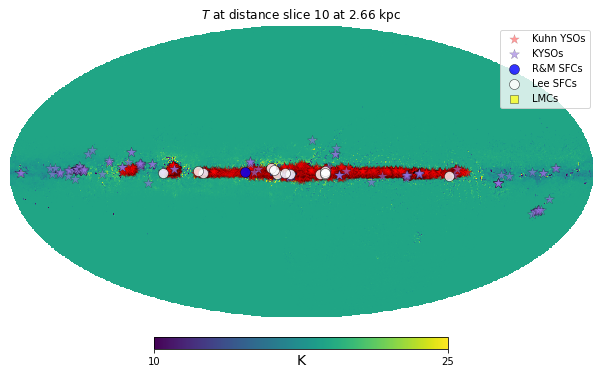

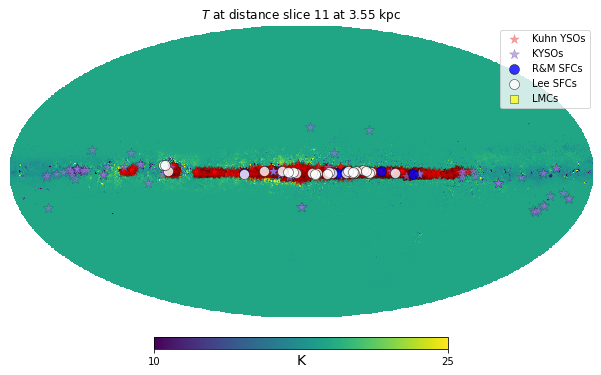

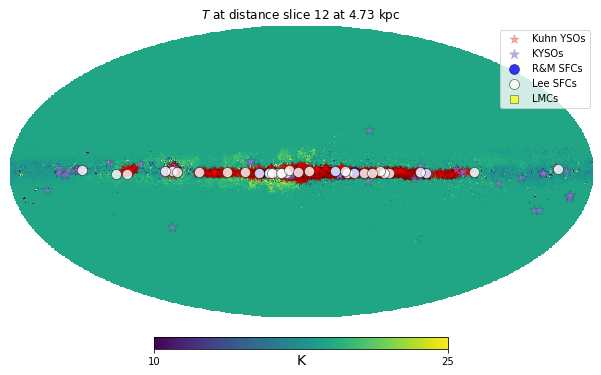

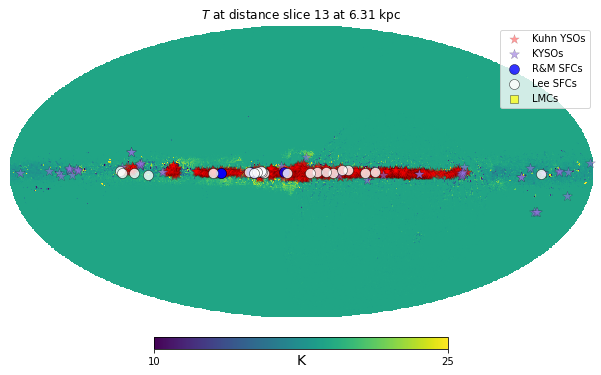

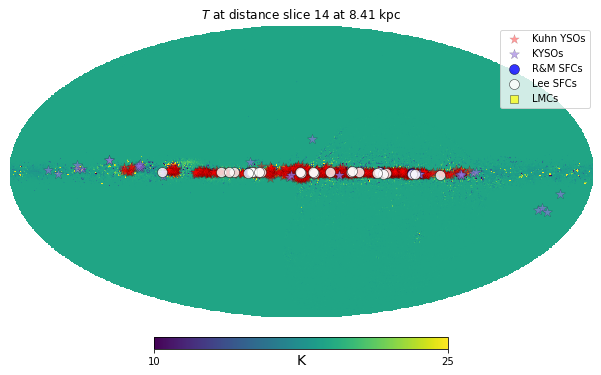

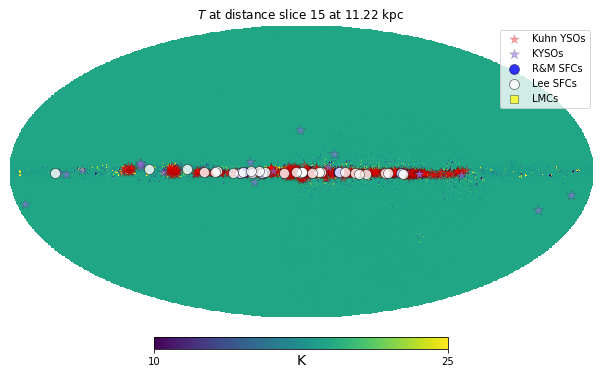

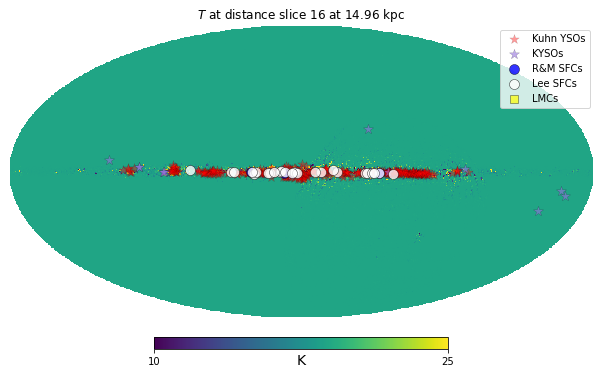

In [14]:
Ts = data_dict1["temperatures"]
model_nslices = data_dict1["nr_of_distance_bins"]
model_dist_slices = data_dict1["distance_slices"]

for ds_index in range(model_nslices):                                 
        hp.mollview(Ts[:,ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')
        hp.projscatter(l_ysos_sliced[ds_index], b_ysos_sliced[ds_index], lonlat=True, marker='*', s=100, color='red', alpha=0.4, edgecolor='black', linewidth=0.2) #Added plotting positions of sf tracer
        hp.projscatter(l_kyso_sliced[ds_index], b_kyso_sliced[ds_index], lonlat=True, marker='*', s=110, color='mediumpurple', alpha=0.6, edgecolor='black', linewidth=0.2) 
        hp.projscatter(l_sfc_sliced[ds_index], b_sfc_sliced[ds_index], lonlat = True, s = 100, marker='o', alpha = 0.8, color='blue', edgecolor='black', linewidth=0.5) 
        hp.projscatter(l_lee_sliced[ds_index], b_lee_sliced[ds_index], lonlat=True, s = 100, marker='o', alpha = 0.8, color='white', edgecolor='black', linewidth=0.5) #Added plotting positions of sf tracer
        hp.projscatter(l_clouds_sliced[ds_index], b_clouds_sliced[ds_index], lonlat=True, s = 80, marker='s', alpha = 0.7, color='yellow', edgecolor='black', linewidth=0.5)
        plt.legend(['Kuhn YSOs', 'KYSOs', 'R&M SFCs', 'Lee SFCs', 'LMCs'])
        #plt.savefig('tempmap_{}.pdf'.format(ds_index))

In [24]:
l_ysos_filtered, b_ysos_filtered = calc.remove_tracers_in_mask(l_ysos_sliced, b_ysos_sliced, model_nslices)
l_kyso_filtered, b_kyso_filtered = calc.remove_tracers_in_mask(l_kyso_sliced, b_kyso_sliced, model_nslices)
l_sfc_filtered, b_sfc_filtered = calc.remove_tracers_in_mask(l_sfc_sliced, b_sfc_sliced, model_nslices)
l_lee_filtered, b_lee_filtered = calc.remove_tracers_in_mask(l_lee_sliced, b_lee_sliced, model_nslices)

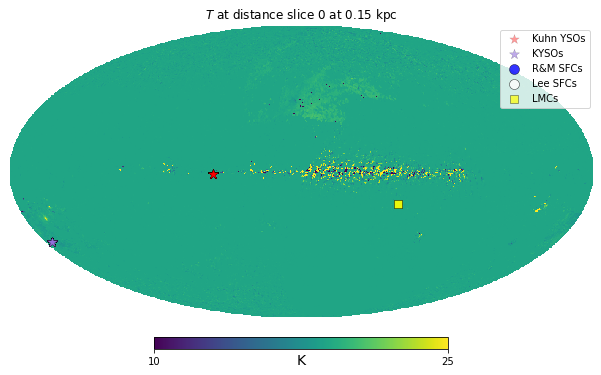

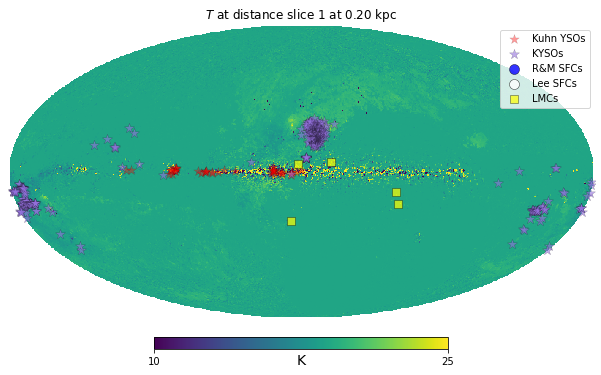

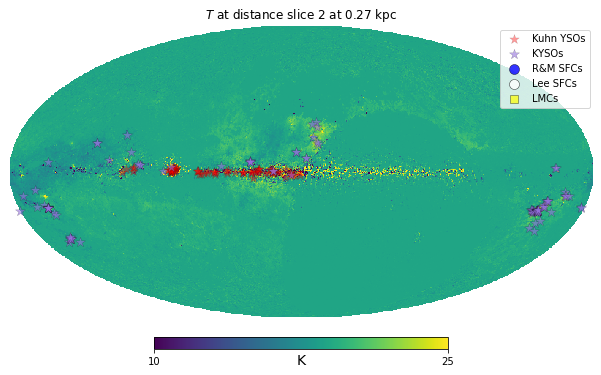

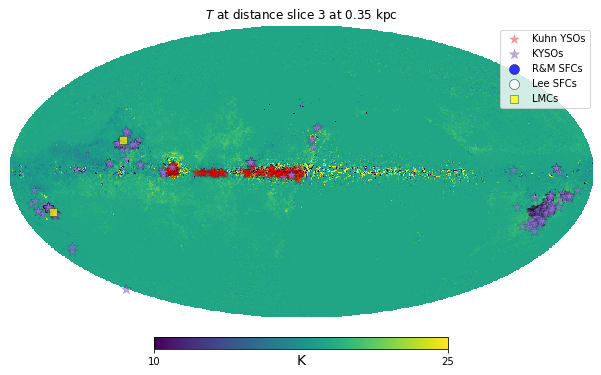

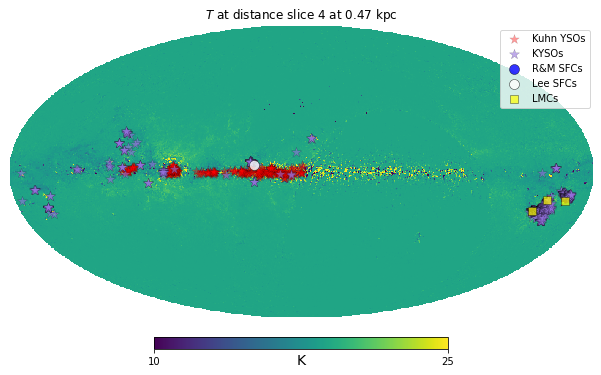

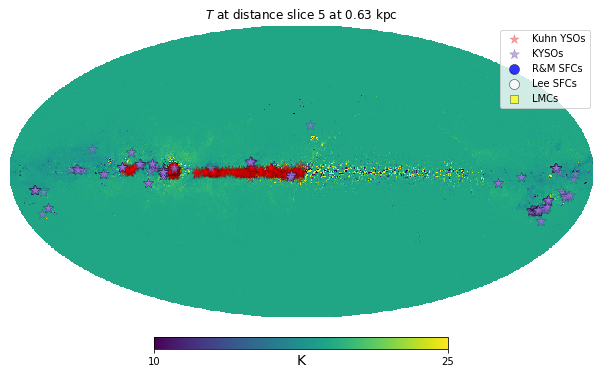

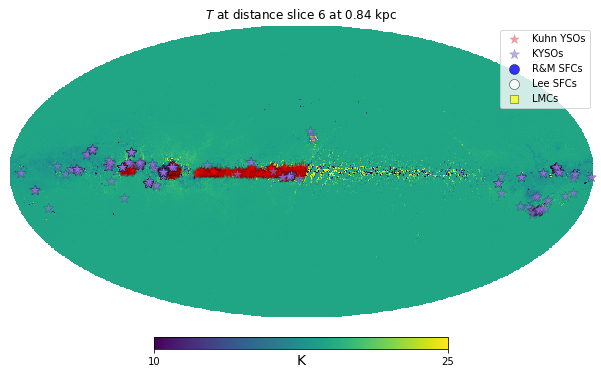

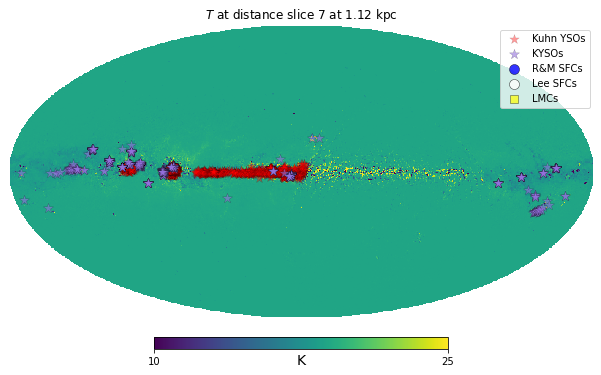

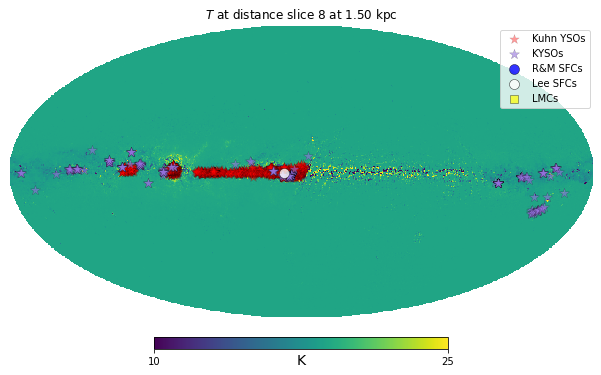

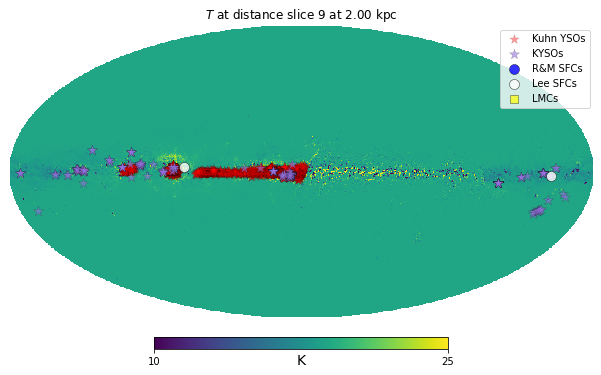

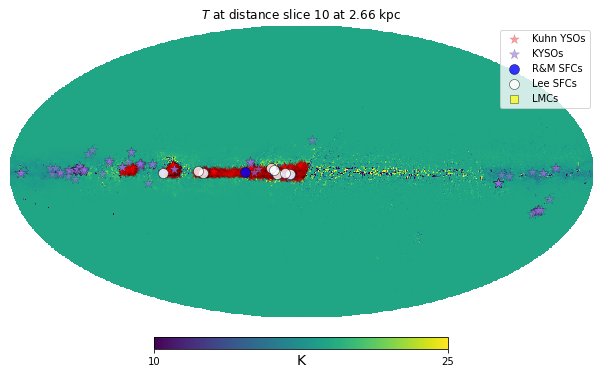

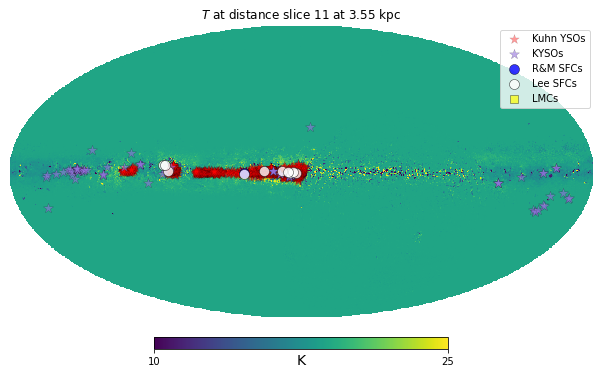

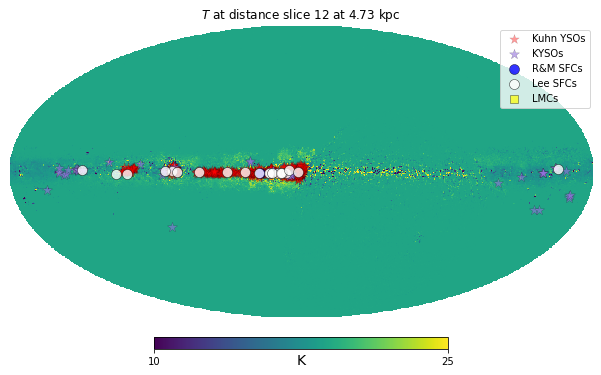

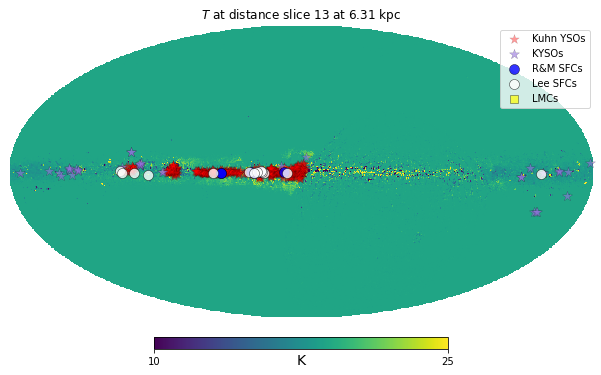

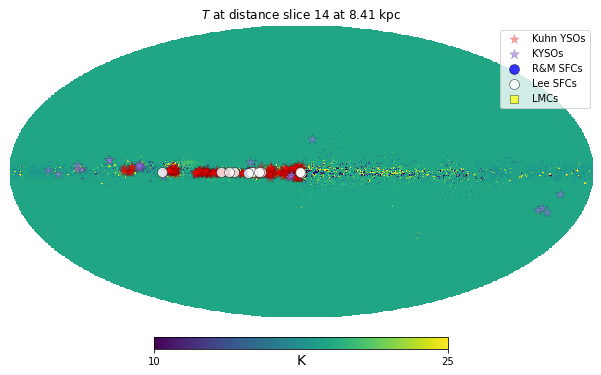

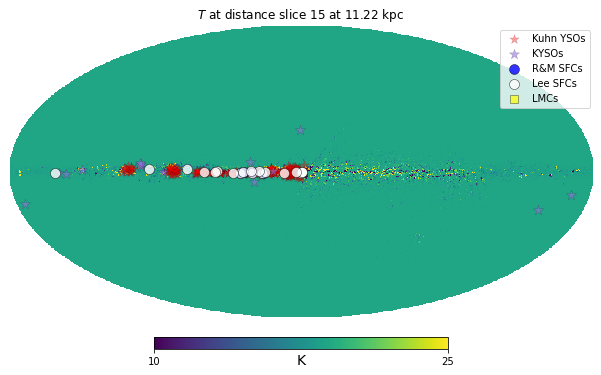

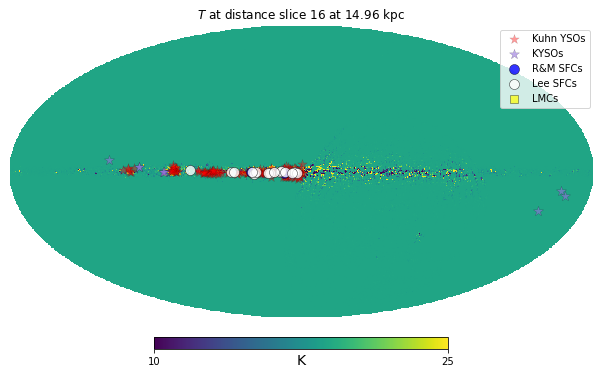

In [18]:
for ds_index in range(model_nslices):
    hp.mollview(Ts[:,ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')
    hp.projscatter(l_ysos_filtered[ds_index], b_ysos_filtered[ds_index], lonlat=True, marker='*', s=100, color='red', alpha=0.4, edgecolor='black', linewidth=0.2) #Added plotting positions of sf tracer
    hp.projscatter(l_kyso_filtered[ds_index], b_kyso_filtered[ds_index], lonlat=True, marker='*', s=110, color='mediumpurple', alpha=0.6, edgecolor='black', linewidth=0.2)
    hp.projscatter(l_sfc_filtered[ds_index], b_sfc_filtered[ds_index], lonlat = True, s = 100, marker='o', alpha = 0.8, color='blue', edgecolor='black', linewidth=0.5)
    hp.projscatter(l_lee_filtered[ds_index], b_lee_filtered[ds_index], lonlat=True, s = 100, marker='o', alpha = 0.8, color='white', edgecolor='black', linewidth=0.5) #Added plotting positions of sf tracer
    hp.projscatter(l_clouds_sliced[ds_index], b_clouds_sliced[ds_index], lonlat=True, s = 80, marker='s', alpha = 0.7, color='yellow', edgecolor='black', linewidth=0.5)
    plt.legend(['Kuhn YSOs', 'KYSOs', 'R&M SFCs', 'Lee SFCs', 'LMCs'])
    plt.show()



In [20]:
# for ds_index in range(model_nslices):
#     vf.plot_healpix_mollview(Ts[:,ds_index], Nside, np.arange(Npix), Npix, title=r"$T$ at distance slice "+str(ds_index) +\
#                                    " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",min=10,max=25, unit='K',declination_mask=True)